# Initialization

In [59]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from matplotlib import gridspec

from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline, make_union, FeatureUnion
from sklearn.model_selection import train_test_split

from pandas import Grouper

In [2]:
train_url='https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'

train=pd.read_csv(train_url, compression='gzip')

# Data exploration

In [3]:
train.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [4]:
train.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [5]:
train.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
24650,None,297.13,0.0,0.0,1,Clear,sky is clear,2016-07-03 20:00:00,2563
11363,None,271.80,0.0,0.0,90,Mist,mist,2014-01-10 16:00:00,6235
14622,None,289.92,0.0,0.0,0,Clear,Sky is Clear,2014-05-25 01:00:00,740
1322,None,282.01,0.0,0.0,75,Clouds,broken clouds,2012-11-20 07:00:00,6824
20506,None,273.92,0.0,0.0,90,Snow,light snow,2016-01-08 12:00:00,4879


# Visualize the data

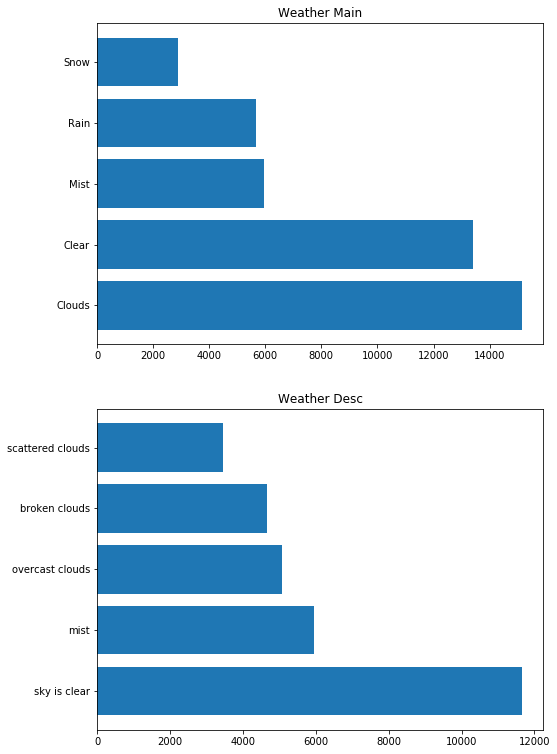

In [6]:
plt.figure(figsize=(8, 13))
plt.subplot(211)
df=train.weather_main.value_counts().head(5)
plt.barh(df.index, df)
plt.title('Weather Main')
df=train.weather_description.value_counts().head(5)
plt.subplot(212)
plt.barh(df.index, df)
plt.title('Weather Desc')
#plt.subplots_adjust(hspace=0.5)
plt.show()


Text(0.5, 0.98, 'Traffic distribution over holidays')

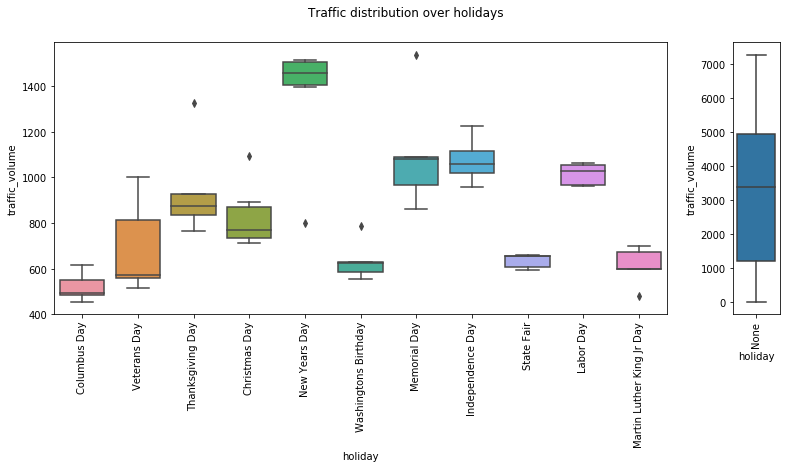

In [7]:
# Plot figure with subplots of different sizes
fig = plt.figure(figsize=(13,5))
# set up subplot grid
#gridspec.GridSpec(15, 12)

rows=1
columns=13 # 11 holidays + 1 no holiday (None) + 1 for labels
# large subplot
plt.subplot2grid((rows,columns), (0,0), colspan=11, rowspan=rows)
ax=sns.boxplot(
    x='holiday',
    y='traffic_volume',
    data=train[train["holiday"] != "None"],
)
plt.setp(ax.get_xticklabels(), rotation=90)

# small subplot
plt.subplot2grid((rows,columns), (0, columns-1), rowspan=rows)
ax=sns.boxplot(
    x='holiday',
    y='traffic_volume',
    data=train[train["holiday"] == "None"],
)
plt.setp(ax.get_xticklabels(), rotation=90)

fig.suptitle("Traffic distribution over holidays")

# Feature selection

In [8]:
features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', ]

target = ['traffic_volume']

In [9]:
X = train[features].values
y = train.traffic_volume.values

# Test data for validation

Hold back 10% of the data for test. There are 42K records in all, so we hold back 4.2K records. We use KFold validation with number of folds = 3 that gives 12K records in the validation set in each iteration.


In [10]:
test_size=0.10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=41)


# Define model

In [11]:
mlp = MLPRegressor(hidden_layer_sizes=(100,100), max_iter=300, alpha=1e-4,
                    solver='adam', verbose=False, tol=1e-4, random_state=1,
                    learning_rate_init=.001)

# Fit the model

Imputation with missing indicator gives a slightly better score on the test compared to just the imputation without missing indicator.
Acknowledgements - https://scikit-learn.org/stable/modules/impute.html#impute

Create pipeline to transform the data, scale it and use MLP regressor.

In [12]:
results = []
transformer = FeatureUnion(
transformer_list=[
    ('features', SimpleImputer(strategy='mean'))
    ,('indicators', MissingIndicator())
])

reg = make_pipeline(transformer, StandardScaler(), mlp)
                       


In [13]:
kfold = KFold(n_splits=3, shuffle=True)


In [14]:
cv_scores = []
for t, val in kfold.split(X_train, y_train):
    reg.fit(X_train[t], y_train[t])
    #print("Model fit...")
    cv_score = reg.score(X_train[val], y_train[val])
    print("Validation score for regressor... %.4f" % cv_score)
    cv_scores.append(cv_score)
    #print("loss", mlp.loss_)
    #print("coefs", mlp.coefs_)
    #print("intercepts", mlp.intercepts_)
    #print("n_iter", mlp.n_iter_)
    #print("n_layers", mlp.n_layers_)
    #print("n_outputs", mlp.n_outputs_)
    #print("out_activation", mlp.out_activation_)



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Validation score for regressor... 0.0633


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Validation score for regressor... 0.0577


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Validation score for regressor... 0.0208


# Evaluate accuracy

In [15]:
print("Generating test scores for regressor... ")

score = reg.score(X_test, y_test)
print("Test score for regressor... %.4f" % score)
#results.append((model, score))


Generating test scores for regressor... 
Test score for regressor... 0.0605


# Make predictions

In [16]:
predictions = reg.predict(X_test)
predictions[0]

3110.09048579338

In [17]:
y_test[0]

2714

Text(0.5, 1.0, "Plot first 50 target 'overall' scores and their predictions.")

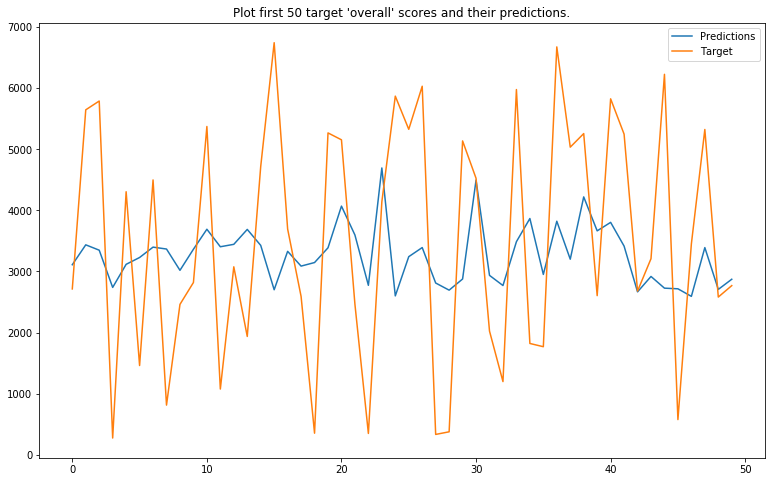

In [18]:
num=50
plt.figure(figsize=(13,8))
plt.plot(predictions[:num])
plt.plot(y_test[:num])
plt.legend(("Predictions", "Target"))
plt.title("Plot first {0} target 'overall' scores and their predictions.".format(num))

# Feature engineering

Create numerical columns representing categorical data.

In [19]:
train.holiday.unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [20]:
train['isHoliday'] = np.where(train.holiday == 'None', False, True)


In [21]:
train.weather_main.unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [22]:
train['weather_main_num'] = train.weather_main.map({
        '?':0, 'Clouds':10, 'Clear':20, 'Rain':30, 'Drizzle':40, 
        'Mist':50, 'Haze':60, 'Fog':70, 'Thunderstorm':80, 
        'Snow':90, 'Squall':100, 'Smoke':110
    })

In [23]:
train.weather_description.unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog',
       'proximity shower rain', 'drizzle', 'moderate rain',
       'heavy intensity rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'proximity thunderstorm with rain',
       'heavy snow', 'heavy intensity drizzle', 'snow',
       'thunderstorm with heavy rain', 'freezing rain', 'shower snow',
       'light rain and snow', 'light intensity shower rain', 'SQUALLS',
       'thunderstorm with rain', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'Sky is Clear', 'very heavy rain',
       'thunderstorm with light drizzle', 'light snow',
       'thunderstorm with drizzle', 'smoke', 'shower drizzle',
       'light shower snow', 'sleet'], dtype=object)

In [25]:
train['weather_description'] = np.where(train.weather_description == 'Sky is Clear', 'sky is clear', 
                                        train.weather_description)

In [26]:
train['weather_description_num'] = train.weather_description.map({
        '?':0, 'scattered clouds':11, 'broken clouds':12, 'overcast clouds':13,
       'sky is clear':21, 'few clouds':14, 'light rain':31,
       'light intensity drizzle':41, 'mist':51, 'haze':61, 'fog':71,
       'proximity shower rain':32, 'drizzle':42, 'moderate rain':33,
       'heavy intensity rain':34, 'proximity thunderstorm':81,
       'thunderstorm with light rain':82, 'proximity thunderstorm with rain':83,
       'heavy snow':91, 'heavy intensity drizzle':43, 'snow':92,
       'thunderstorm with heavy rain':84, 'freezing rain':93, 'shower snow':94,
       'light rain and snow':35, 'light intensity shower rain':36, 'SQUALLS':100,
       'thunderstorm with rain':85, 'proximity thunderstorm with drizzle':86,
       'thunderstorm':87, 'Sky is Clear':22, 'very heavy rain':37,
       'thunderstorm with light drizzle':88, 'light snow':95,
       'thunderstorm with drizzle':89, 'smoke':111, 'shower drizzle':43,
       'light shower snow':96, 'sleet':97
    })

In [27]:
df=train[['weather_description_num', 'weather_description']]
df=df.sort_values(by='weather_description_num')

Text(0.5, 1.0, 'Traffic distribution over weather')

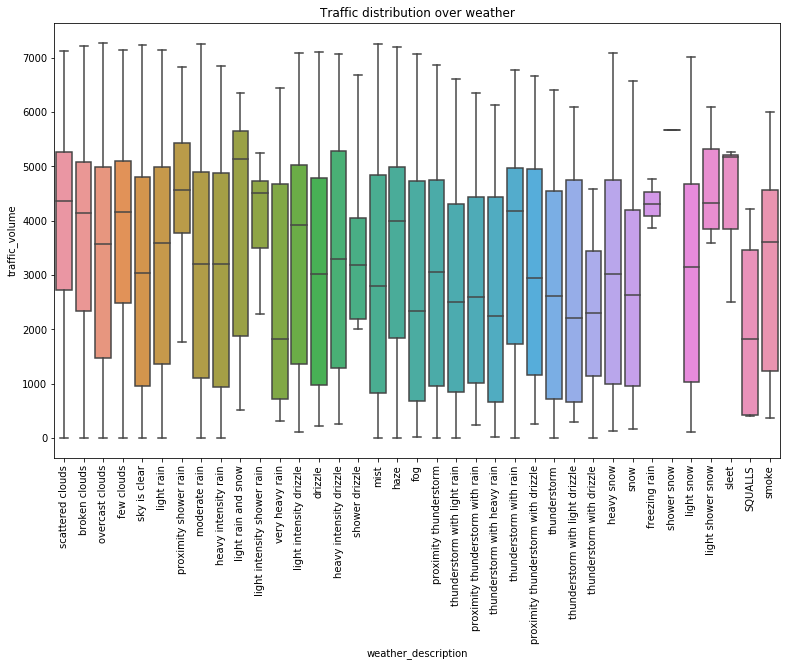

In [28]:
plt.figure(figsize=(13, 8))

ax=sns.boxplot(
    x='weather_description',
    y='traffic_volume',
    order=df.weather_description.unique(),
    data=train,
)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title("Traffic distribution over weather")

In [50]:
holiday_weather = train[train['isHoliday']]

Text(0.5, 1.0, 'Traffic distribution on holidays and weather')

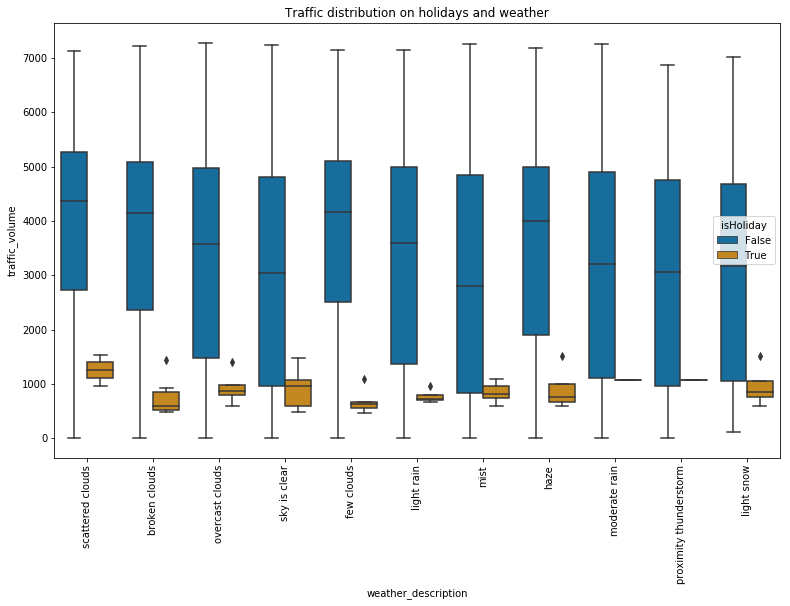

In [91]:
f = (train
         .loc[:, ['weather_description', 'traffic_volume', 'isHoliday']]
    )

f = f[f['weather_description'].isin(holiday_weather.weather_description.unique())]

plt.figure(figsize=(13, 8))
sns.set_palette("colorblind")
ax=sns.boxplot(x="weather_description"
            , y="traffic_volume"
            , hue='isHoliday'
            , data=f)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title("Traffic distribution on holidays and weather")

In [55]:
#print(train.date_time.unique())
print(train.date_time.sample(5))

4499     2013-03-24 08:00:00
40061    2017-12-25 04:00:00
28777    2016-12-03 09:00:00
35369    2017-07-16 00:00:00
17592    2015-08-20 23:00:00
Name: date_time, dtype: object


In [92]:
train.date_time = pd.to_datetime(train.date_time,infer_datetime_format=True)
#train.date_time.sample(5)

In [93]:
#train.groupby(train.date_time.dt.hour).mean().head()

Traffic patterns during the day


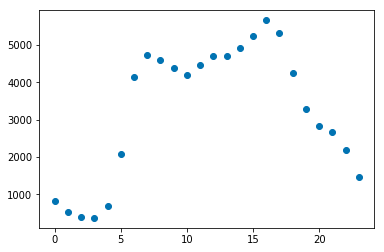

In [81]:
print("Traffic pattern during the day")
df = train.groupby(train.date_time.dt.hour).mean()
plt.scatter(df.index, df.traffic_volume)
plt.show()

Traffic pattern over time


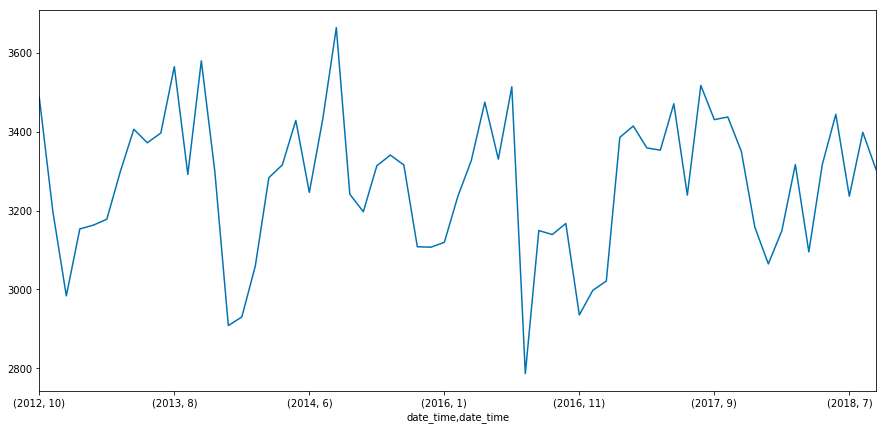

In [94]:
print("Traffic pattern over time")
fig, ax = plt.subplots(figsize=(15,7))
train.groupby([train.date_time.dt.year, train.date_time.dt.month]).mean()['traffic_volume'].plot(ax=ax)

In [89]:
train.groupby([train.date_time.dt.year, train.date_time.dt.month]).mean()['traffic_volume'].unstack()

date_time,1,2,3,4,5,6,7,8,9,10,11,12
date_time,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3486.740373,3198.431847,2983.665635
2013,3153.654391,3163.216179,3178.204196,3299.192758,3406.630851,3372.327249,3397.068182,3565.536923,3292.039749,3580.423077,3299.594915,2908.321226
2014,2930.078780,3059.722963,3283.589431,3316.219118,3429.088689,3246.413437,3433.305471,3664.544118,NaN,NaN,NaN,NaN
2015,NaN,NaN,NaN,NaN,NaN,3241.736559,3197.291715,3313.879070,3341.111111,3315.996497,3108.342213,3107.174957
2016,3119.504146,3235.977273,3327.467105,3475.434839,3330.711732,3514.357625,2786.311275,3149.538741,3139.309554,3167.510316,2935.204290,2997.709091
2017,3021.324561,3386.042017,3414.931792,3359.195223,3353.585084,3471.363525,3239.432941,3517.937500,3431.079503,3437.757543,3350.451422,3158.147560
2018,3064.751131,3148.782338,3317.182238,3095.325942,3317.254879,3444.641876,3236.646651,3398.878436,3302.213904,NaN,NaN,NaN


Traffic pattern over time, stacked on months


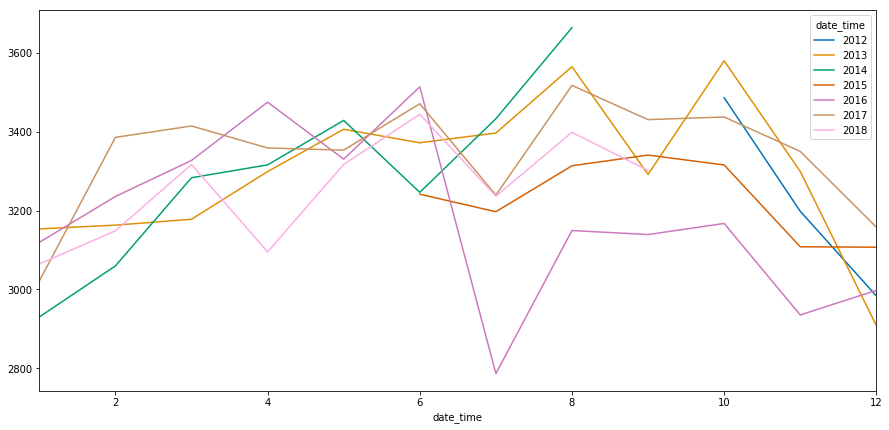

In [96]:
print("Traffic pattern over time, stacked on years")
fig, ax = plt.subplots(figsize=(15,7))
train.groupby([train.date_time.dt.month, train.date_time.dt.year]).mean()['traffic_volume'].unstack().plot(ax=ax)

Traffic pattern over time, stacked on months


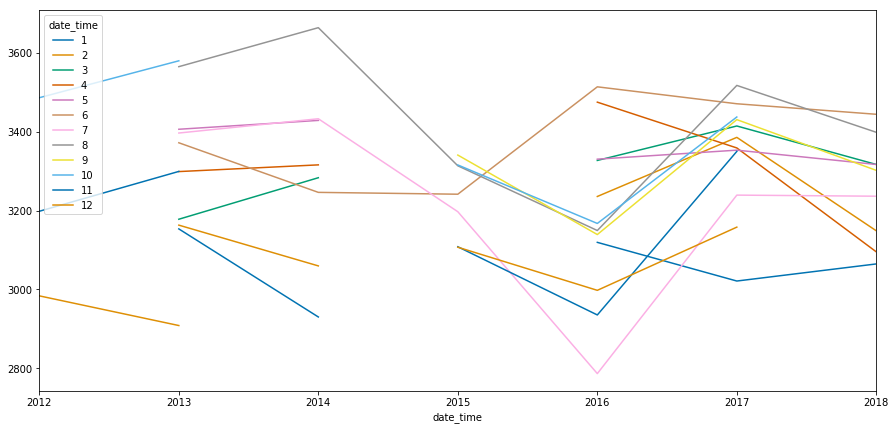

In [97]:
print("Traffic pattern over time, stacked on months")
fig, ax = plt.subplots(figsize=(15,7))
train.groupby([train.date_time.dt.year, train.date_time.dt.month]).mean()['traffic_volume'].unstack().plot(ax=ax)

# Feature selection